# FBA QUANT AP HW8
Kim Soo Wan(hse07088@snu.ac.kr)
***

In [1]:
import pandas as pd 
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import stats

### **Data Description**
Table1. Market.json
- mdate: 월별 기준일 (월말일자)
- market: 시장 포트폴리오 월간 수익률
- risk_free: 무위험 자산 월간 수익률
- SnP500: S&P500 지수 월간 수익률

Table2. Header.json
- cusip: 국제 증권번호
- Ticker: 티커
- Ticker_alt: 대체 티커
- Legal: 법인명
- delist_date: 상장폐지일
- GICS_code: 산업분류코드

Table3. LowVolatility.json
- cusip: 국제 증권번호
- mdate: 월별 기준일 (월말일자)
- open: 개별증권의 월별 시가
- close: 개별증권의 월별 수정 종가
- return: 개별증권의 월간 수익률 (배당 수익률 및 액면 분할 등 고려)
- cap: 개별증권의 월간 시가총액 평균
- volume: 개별증권의 월간 거래량 평균
- beta: 개별증권의 베타
- short_cost: 개별증권의 공매도 비용
- 5yBeta: 1st Low Volatility Factor, 개별증권 5년 베타
- 5yROEVol: 2nd Low Volatility Factor, 개별증권 5년 ROE 변동성
- 5yPriceVol: 3rd Low Volatility Factor, 개별증권 5년 가격 변동성

### **Problem 1. Low Volatility – Long Portfolio**

Low Volatility Factor Portfolio가 시장대비 높은 위험조정 수익률을 보임을 확인한다.

1. Data Load<br/>
LowVolatility.json 파일을 pandas의 DataFrame형태로 불러온다. 
Market.json 파일을 pandas의 DataFrame 형태로 불러온다.

2. Z-Scoring<br/>
Low Volatility Data Frame 내의 Low Volatility Factor 에 해당하는 3개의 필드 5yBeta, 5yROEVol, 5yPriceVol 에 대해 각 필드의 Score를 Z-Score로 변환한 Z_5yBeta, Z_5yROEVol, Z_5yPriceVol 필드를 생성한다. 결측치(NaN)가 있을 경우 0으로 처리한다. (결측치가 평균에 존재함을 가정)<br/><br/>Z-Scoring하는 방법은 아래와 같다. mdate(월별 기준일자)가 동일한 증권들을 대상으로 Normalization을 진행한다. $$Z_{score}=(score-μ_t)/σ_t$$ $$μ_t=\text{mean of the score at month t}$$ $$σ_t=\text{standard deviation of the score at month t}$$ 이후 모든 월에 대해 주어진 Score를 Normalization된 Z-Score로 변환한다. Z-Scoring이란?: https://www.investopedia.com/terms/z/zscore.asp 

3. Score Aggregation<br/>
Z-Scoring된 필드 값을 더하여 하나의 Score를 생성한다. 이때 적당한 가중치를 부여해 합산할 수 있다.

4. Construct Long Portfolio<br/>
합산된 Z-Score를 기준으로 하위 30% 종목 (변동성이 낮은 종목)을 매수하여 Long Portfolio를 구성한다.  개별증권의 가중치는 시가총액 가중방식을 사용한다. 보유기간은 18개월이며 보유기간이 종료될 경우, 해당시점에서 합산된 Z-Score의 하위 30% 종목으로 포트폴리오를 새로 구성한다. (리밸런싱)

5. Comparison to Benchmark<br/>
시장 포트폴리오와 위험조정수익률 (Sharpe Ratio, Information Ratio)를 비교한다. 
(변동성이 작은 종목으로 포트폴리오를 구성했으니,  Risk-Return Payoff에 의해 Low Volatility Factor Portfolio의 누적수익률이 시장 포트폴리오보다 작게 나타나는 게 정상입니다. 다만, Sharpe Ratio등 위험 조정 수익률을 고려했을 때, 시장 포트폴리오보다 높은 성과를 보여야 합니다.)

6.  Visualization<Br/>
누적수익률, MDD 등을 시각화 해서 나타낸다.


In [2]:
#1. Data Load
with open("data\\LowVolatility.json", "r") as low_vol_file:
    low_vol_dict = json.load(low_vol_file)
    
with open("data\\Market.json", "r") as market_file:
    market_dict = json.load(market_file)
    
with open("data\\Header.json", "r") as header_file:
    header_dict = json.load(header_file)

In [3]:
low_vol = pd.DataFrame(list(low_vol_dict.values())[0])
market = pd.DataFrame(list(market_dict.values())[0])
header = pd.DataFrame(list(header_dict.values())[0])

In [4]:
low_vol

,cusip,mdate,open,close,return,cap,volume,beta,short_cost,5yBeta,5yROEVol,5yPriceVol
0,000957100,1970-01-31,34.875,37.750,0.082437,46734.0,1.090000e+04,0.721091,-0.0092,0.721091,NaN,3.688897
1,001007103,1970-01-31,25.250,28.000,0.112943,147560.0,1.068000e+05,-0.484350,-0.0038,-0.484350,NaN,1.519457
2,001412105,1970-01-31,4.500,4.000,-0.111111,13100.0,5.520000e+04,2.088036,-0.0340,2.088036,NaN,3.985623
3,001476100,1970-01-31,9.875,9.375,-0.050633,38550.0,1.253000e+05,1.165014,-0.0092,1.165014,NaN,3.843832
4,001688100,1970-01-31,17.625,21.000,0.205787,375081.0,2.460000e+05,1.917081,-0.0037,1.917081,NaN,3.247371
...,...,...,...,...,...,...,...,...,...,...,...,...
2643446,98986M103,2021-12-31,9.970,7.920,-0.117637,346199.0,6.318261e+06,0.283821,-0.0092,0.283821,0.377692,4.384531
2643447,98986T108,2021-12-31,6.400,9.070,0.417188,10270941.0,1.232632e+09,0.442438,-0.0037,0.442438,0.067953,2.547910
2643448,98986X109,2021-12-31,2.880,2.610,-0.093750,107579.0,1.538238e+07,5.036167,-0.0340,5.036167,0.137314,4.963209
2643449,G65163100,2021-12-31,7.300,4.150,-0.431507,2506160.0,9.260847e+07,0.331590,-0.0037,0.331590,NaN,1.511431


In [5]:
low_vol['mdate'] = pd.to_datetime(low_vol['mdate']).dt.to_period('M')
low_vol.set_index(['cusip', 'mdate'], inplace=True)

In [6]:
print(pd.isna(low_vol[['cap','return']]).sum().sum())
# if interpolate,,, but it took too much time, so I have just droped them

for cusip, g in low_vol.groupby(level=0):
    low_vol.loc[cusip, 'cap'] = g['cap'].interpolate(method='linear')
    low_vol.loc[cusip, 'return'] = g['return'].interpolate(method='linear')

low_vol.dropna(subset=['cap','return'], inplace=True)
print(pd.isna(low_vol[['cap','return']]).sum().sum())

132486
0


In [7]:
low_vol

,,open,close,return,cap,volume,beta,short_cost,5yBeta,5yROEVol,5yPriceVol
cusip,mdate,,,,,,,,,,
000957100,1970-01,34.875,37.750,0.082437,46734.0,1.090000e+04,0.721091,-0.0092,0.721091,NaN,3.688897
001007103,1970-01,25.250,28.000,0.112943,147560.0,1.068000e+05,-0.484350,-0.0038,-0.484350,NaN,1.519457
001412105,1970-01,4.500,4.000,-0.111111,13100.0,5.520000e+04,2.088036,-0.0340,2.088036,NaN,3.985623
001476100,1970-01,9.875,9.375,-0.050633,38550.0,1.253000e+05,1.165014,-0.0092,1.165014,NaN,3.843832
001688100,1970-01,17.625,21.000,0.205787,375081.0,2.460000e+05,1.917081,-0.0037,1.917081,NaN,3.247371
...,...,...,...,...,...,...,...,...,...,...,...
98985X100,2021-12,6.690,5.200,-0.222720,535834.0,1.920686e+07,0.961761,-0.0058,0.961761,0.000000,14.419219
98986M103,2021-12,9.970,7.920,-0.117637,346199.0,6.318261e+06,0.283821,-0.0092,0.283821,0.377692,4.384531
98986T108,2021-12,6.400,9.070,0.417188,10270941.0,1.232632e+09,0.442438,-0.0037,0.442438,0.067953,2.547910


In [8]:
market['mdate'] = pd.to_datetime(market['mdate']).dt.to_period()
market.set_index('mdate', inplace=True)
market

,market,risk_free,SnP500
mdate,,,
1970-01,-0.073254,0.0060,-0.076472
1970-02,0.056706,0.0062,0.052693
1970-03,-0.004729,0.0057,0.001453
1970-04,-0.105318,0.0050,-0.090483
1970-05,-0.064346,0.0053,-0.060967
...,...,...,...
2021-11,-0.018350,0.0000,-0.008334
2021-12,0.033341,0.0001,0.043613
2022-01,-0.059822,0.0000,-0.052585


In [9]:
header['delist_date'] = pd.to_datetime(header['delist_date'])
header.set_index('cusip', inplace=True)
header

,Ticker,Ticker_alt,Legal,delist_date,GICS_code
cusip,,,,,
000021303,3ANAFE,ANAFF,A & A International Industries Inc,2001-06-18,30202010
000032102,AE.2,AE,A & E Plastik Pak Inc,1978-06-30,
000165100,AMFD.,AMFD,A & M Food Services Inc,1986-07-31,25301040
000209106,SODA.1,SODA,A & W Brands Inc,1993-10-31,30201030
000307108,AACH,AAC,AAC Holdings Inc,NaT,35102020
...,...,...,...,...,...
Y8565N300,TNK,TNK,Teekay Tankers Ltd,NaT,10102040
Y8977Y100,RIGP,RIGP,Transocean Partners LLC,2016-12-09,10101010
Y93691106,VRGY,VRGY,Verigy Ltd,2011-07-06,45301010


In [10]:
#2 Z-scoring
low_vol = low_vol.swaplevel(0,1)
low_vol_mdate_mean = low_vol.groupby(level=0)[['5yBeta', '5yROEVol', '5yPriceVol']].mean().loc[low_vol.index.get_level_values(level=0),['5yBeta', '5yROEVol', '5yPriceVol']].set_index(low_vol.index)
low_vol_mdate_std = low_vol.groupby(level=0)[['5yBeta', '5yROEVol', '5yPriceVol']].std().loc[low_vol.index.get_level_values(level=0),['5yBeta', '5yROEVol', '5yPriceVol']].set_index(low_vol.index)
low_vol[['Z_5yBeta', 'Z_5yROEVol', 'Z_5yPriceVol']] = (low_vol.loc[:,['5yBeta', '5yROEVol', '5yPriceVol']] - low_vol_mdate_mean.loc[:,['5yBeta', '5yROEVol', '5yPriceVol']])/low_vol_mdate_std.loc[:,['5yBeta', '5yROEVol', '5yPriceVol']]
low_vol.loc[:,['Z_5yBeta', 'Z_5yROEVol', 'Z_5yPriceVol']] = (low_vol.loc[:,['Z_5yBeta', 'Z_5yROEVol', 'Z_5yPriceVol']]).fillna(0)
low_vol

open   close    return         cap        volume  \
mdate   cusip                                                           
1970-01 000957100  34.875  37.750  0.082437     46734.0  1.090000e+04   
        001007103  25.250  28.000  0.112943    147560.0  1.068000e+05   
        001412105   4.500   4.000 -0.111111     13100.0  5.520000e+04   
        001476100   9.875   9.375 -0.050633     38550.0  1.253000e+05   
        001688100  17.625  21.000  0.205787    375081.0  2.460000e+05   
...                   ...     ...       ...         ...           ...   
2021-12 98985X100   6.690   5.200 -0.222720    535834.0  1.920686e+07   
        98986M103   9.970   7.920 -0.117637    346199.0  6.318261e+06   
        98986T108   6.400   9.070  0.417188  10270941.0  1.232632e+09   
        98986X109   2.880   2.610 -0.093750    107579.0  1.538238e+07   
        G65163100   7.300   4.150 -0.431507   2506160.0  9.260847e+07   

                       beta  short_cost    5yBeta  5yROEVol  5yPriceVol  \
mdate   cusip                                                             
1970-01 000957100  0.721091     -0.0092  0.721091       NaN    3.688897   
        001007103 -0.484350     -0.0038 -0.484350       NaN    1.519457   
        001412105  2.088036     -0.0340  2.088036       NaN    3.985623   
        001476100  1.165014     -0.0092  1.165014       NaN    3.843832   
        001688100  1.917081     -0.0037  1.917081       NaN    3.247371   
...                     ...         ...       ...       ...         ...   
2021-12 98985X100  0.961761     -0.0058  0.961761  0.000000   14.419219   
        98986M103  0.283821     -0.0092  0.283821  0.377692    4.384531   
        98986T108  0.442438     -0.0037  0.442438  0.067953    2.547910   
        98986X109  5.036167     -0.0340  5.036167  0.137314    4.963209   
        G65163100  0.331590     -0.0037  0.331590       NaN    1.511431   

                   Z_5yBeta  Z_5yROEVol  Z_5yPriceVol  
mdate   cusip                                          
1970-01 000957100 -0.695710    0.000000     -0.433789  
        001007103 -2.080111    0.000000     -0.634021  
        001412105  0.874172    0.000000     -0.406402  
        001476100 -0.185881    0.000000     -0.419489  
        001688100  0.677838    0.000000     -0.474540  
...                     ...         ...           ...  
2021-12 98985X100 -0.712347   -0.040690     -0.016638  
        98986M103 -1.055370   -0.035859     -0.028213  
        98986T108 -0.975113   -0.039821     -0.030331  
        98986X109  1.349213   -0.038934     -0.027545  
        G65163100 -1.031200    0.000000     -0.031527  

[2626555 rows x 13 columns]

In [11]:
#3 Score Aggregation
low_vol['score'] = low_vol[['Z_5yBeta', 'Z_5yROEVol', 'Z_5yPriceVol']].sum(axis=1)
low_vol

open   close    return         cap        volume  \
mdate   cusip                                                           
1970-01 000957100  34.875  37.750  0.082437     46734.0  1.090000e+04   
        001007103  25.250  28.000  0.112943    147560.0  1.068000e+05   
        001412105   4.500   4.000 -0.111111     13100.0  5.520000e+04   
        001476100   9.875   9.375 -0.050633     38550.0  1.253000e+05   
        001688100  17.625  21.000  0.205787    375081.0  2.460000e+05   
...                   ...     ...       ...         ...           ...   
2021-12 98985X100   6.690   5.200 -0.222720    535834.0  1.920686e+07   
        98986M103   9.970   7.920 -0.117637    346199.0  6.318261e+06   
        98986T108   6.400   9.070  0.417188  10270941.0  1.232632e+09   
        98986X109   2.880   2.610 -0.093750    107579.0  1.538238e+07   
        G65163100   7.300   4.150 -0.431507   2506160.0  9.260847e+07   

                       beta  short_cost    5yBeta  5yROEVol  5yPriceVol  \
mdate   cusip                                                             
1970-01 000957100  0.721091     -0.0092  0.721091       NaN    3.688897   
        001007103 -0.484350     -0.0038 -0.484350       NaN    1.519457   
        001412105  2.088036     -0.0340  2.088036       NaN    3.985623   
        001476100  1.165014     -0.0092  1.165014       NaN    3.843832   
        001688100  1.917081     -0.0037  1.917081       NaN    3.247371   
...                     ...         ...       ...       ...         ...   
2021-12 98985X100  0.961761     -0.0058  0.961761  0.000000   14.419219   
        98986M103  0.283821     -0.0092  0.283821  0.377692    4.384531   
        98986T108  0.442438     -0.0037  0.442438  0.067953    2.547910   
        98986X109  5.036167     -0.0340  5.036167  0.137314    4.963209   
        G65163100  0.331590     -0.0037  0.331590       NaN    1.511431   

                   Z_5yBeta  Z_5yROEVol  Z_5yPriceVol     score  
mdate   cusip                                                    
1970-01 000957100 -0.695710    0.000000     -0.433789 -1.129498  
        001007103 -2.080111    0.000000     -0.634021 -2.714132  
        001412105  0.874172    0.000000     -0.406402  0.467771  
        001476100 -0.185881    0.000000     -0.419489 -0.605370  
        001688100  0.677838    0.000000     -0.474540  0.203298  
...                     ...         ...           ...       ...  
2021-12 98985X100 -0.712347   -0.040690     -0.016638 -0.769675  
        98986M103 -1.055370   -0.035859     -0.028213 -1.119442  
        98986T108 -0.975113   -0.039821     -0.030331 -1.045266  
        98986X109  1.349213   -0.038934     -0.027545  1.282734  
        G65163100 -1.031200    0.000000     -0.031527 -1.062727  

[2626555 rows x 14 columns]

In [12]:
#4 Constructing Long Portfolio
monthly_selected = low_vol.groupby(level=0).apply(lambda x: x['score']<x['score'].quantile(0.3)).reset_index(level=1).drop(columns=['mdate'])
monthly_rebalanced_portfolio = low_vol['cap'].copy()
monthly_rebalanced_portfolio.loc[~monthly_selected['score']]=0
monthly_rebalanced_portfolio = monthly_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'})
monthly_rebalanced_portfolio

<ipython-input-12-f68194933417>:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  monthly_rebalanced_portfolio = monthly_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'})


,cusip,portfolio_weight
mdate,,
1970-01,000957100,0.000390
1970-01,001007103,0.001232
1970-01,001412105,0.000000
1970-01,001476100,0.000322
1970-01,001688100,0.000000
...,...,...
2021-12,98985X100,0.000077
2021-12,98986M103,0.000050
2021-12,98986T108,0.001479


In [13]:
rebalance_interval = pd.DateOffset(months=12)
rebalanced_portfolio = None
rebalanced_date = None
custom_rebalanced_portfolio = []
for month, g in monthly_rebalanced_portfolio.groupby(level=0):
    if(not rebalanced_date or pd.Period(rebalanced_date+rebalance_interval, freq='M')<=month):
        rebalanced_date = month.start_time
        rebalanced_portfolio = g
    rebalanced_portfolio.index=[month]*rebalanced_portfolio.shape[0]
    custom_rebalanced_portfolio.append(rebalanced_portfolio[['cusip', 'portfolio_weight']])
custom_rebalanced_portfolio = pd.concat(custom_rebalanced_portfolio).rename_axis('mdate').set_index('cusip',append=True)
custom_rebalanced_portfolio

portfolio_weight
mdate   cusip                      
1970-01 000957100          0.000390
        001007103          0.001232
        001412105          0.000000
        001476100          0.000322
        001688100          0.000000
...                             ...
2021-12 98986M103          0.000050
        98986T108          0.001190
        98986X109          0.000000
        G2124G112          0.000005
        G6S34K105          0.000000

[2603868 rows x 1 columns]

In [15]:
#Comparison
low_vol_port_monthly_return = pd.DataFrame(custom_rebalanced_portfolio['portfolio_weight'].multiply(low_vol['return'], axis='index'))
low_vol_port_monthly_return = low_vol_port_monthly_return.loc[low_vol_port_monthly_return.index.isin(custom_rebalanced_portfolio.index), :]
print(low_vol_port_monthly_return[0].isna().sum())
delisting_fillup = low_vol_port_monthly_return.groupby(level=1).apply(lambda x: x.isna().idxmin())
low_vol_port_monthly_return.loc[delisting_fillup[0].values,:] = low_vol_port_monthly_return.loc[delisting_fillup[0].values,:].apply(lambda x : (~x.isna())*x.fillna(0)+x.isna()*(-custom_rebalanced_portfolio.loc[delisting_fillup[0].values,'portfolio_weight']))
low_vol_port_monthly_return.fillna(0, inplace=True)
low_vol_port_monthly_return = low_vol_port_monthly_return.groupby(level=0).sum()[0]
print(low_vol_port_monthly_return)

87613
mdate
1970-01    0.067860
1970-02    0.016032
1970-03   -0.091640
1970-04   -0.039853
1970-05   -0.056666
             ...   
2021-08   -0.048571
2021-09    0.039862
2021-10   -0.034436
2021-11    0.067904
2021-12   -0.047113
Freq: M, Name: 0, Length: 624, dtype: float64


In [16]:
low_vol_annual_return = (1+low_vol_port_monthly_return).resample('A').prod()-1
low_vol_annual_return

mdate
1970    0.199592
1971    0.044030
1972    0.097621
1973   -0.096037
1974   -0.154889
1975    0.363881
1976    0.253044
1977    0.022327
1978    0.209139
1979    0.150947
1980    0.174525
1981    0.196592
1982    0.351646
1983    0.125130
1984    0.176899
1985    0.305440
1986    0.238538
1987   -0.049353
1988    0.126302
1989    0.184454
1990    0.023060
1991    0.297964
1992    0.106139
1993    0.225731
1994   -0.085138
1995    0.303570
1996    0.175200
1997    0.221920
1998    0.087034
1999    0.032096
2000   -0.141293
2001    0.034428
2002   -0.125228
2003    0.301630
2004    0.116687
2005    0.096905
2006    0.152109
2007   -0.022853
2008   -0.328254
2009    0.164507
2010    0.150818
2011    0.121607
2012    0.169092
2013    0.190439
2014    0.167005
2015    0.044287
2016    0.143216
2017    0.178369
2018    0.019972
2019    0.223147
2020    0.144400
2021    0.092116
Freq: A-DEC, Name: 0, dtype: float64

In [17]:
annual_mkt_data = (1+market).resample('A').prod()-1
annual_mkt_data

,market,risk_free,SnP500
mdate,,,
1970,0.000731,0.065167,0.000977
1971,0.161988,0.043856,0.107867
1972,0.173406,0.038357,0.156330
1973,-0.187496,0.069303,-0.173656
1974,-0.279411,0.080093,-0.297181
1975,0.373580,0.057984,0.315493
1976,0.267802,0.050847,0.191485
1977,-0.029695,0.051265,-0.115019
1978,0.085461,0.071965,0.010621


In [18]:
mkt_monthly_return = market[['market','SnP500']]
mkt_monthly_return

,market,SnP500
mdate,,
1970-01,-0.073254,-0.076472
1970-02,0.056706,0.052693
1970-03,-0.004729,0.001453
1970-04,-0.105318,-0.090483
1970-05,-0.064346,-0.060967
...,...,...
2021-11,-0.018350,-0.008334
2021-12,0.033341,0.043613
2022-01,-0.059822,-0.052585


In [19]:
low_vol_port_total_return = (1+low_vol_annual_return).prod()
low_vol_port_return_std = low_vol_annual_return.std()
low_vol_port_excess_return_arithematic_avg = (low_vol_annual_return-annual_mkt_data.loc[:'2022','risk_free']).mean()
print("Total Compounded Annual Return :", low_vol_port_total_return)
print("Annual Return std :", low_vol_port_return_std)
print("Sharp :", low_vol_port_excess_return_arithematic_avg/low_vol_port_return_std)

Total Compounded Annual Return : 228.5722880780745
Annual Return std : 0.13747204391604215
Sharp : 0.5383979999695503


In [21]:
mkt_annual_return = annual_mkt_data[['market','SnP500']]
mkt_return_total_return = (1+mkt_annual_return).prod()
mkt_annaul_excess_return = annual_mkt_data
mkt_excess_return_arithematic_avg = (mkt_annual_return.apply(lambda x:x-annual_mkt_data['risk_free'], axis=0)).mean()
mkt_return_std = mkt_annual_return.std()
print("Total compounded Return\n", mkt_return_total_return)
print("\nAnnual Return std\n", mkt_return_std)
print("\nSharp\n", mkt_excess_return_arithematic_avg/mkt_return_std)

Total compounded Return
 market    186.345520
SnP500     49.211802
dtype: float64

Annual Return std
 market    0.172598
SnP500    0.163971
dtype: float64

Sharp
 market    0.428177
SnP500    0.276655
dtype: float64


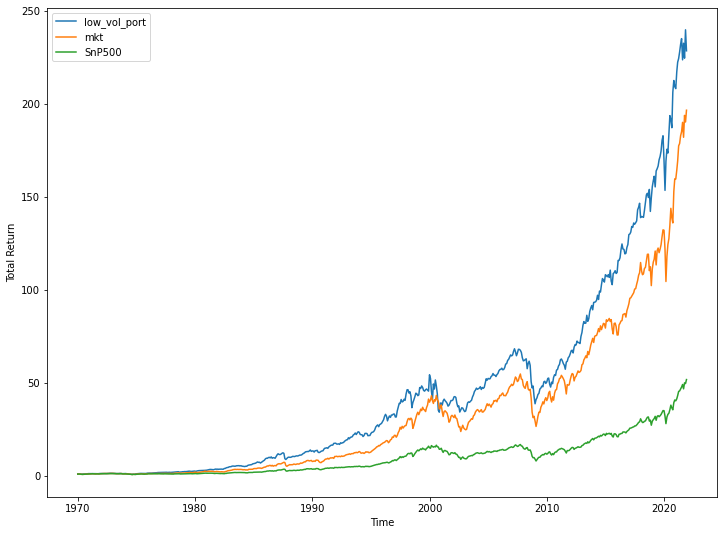

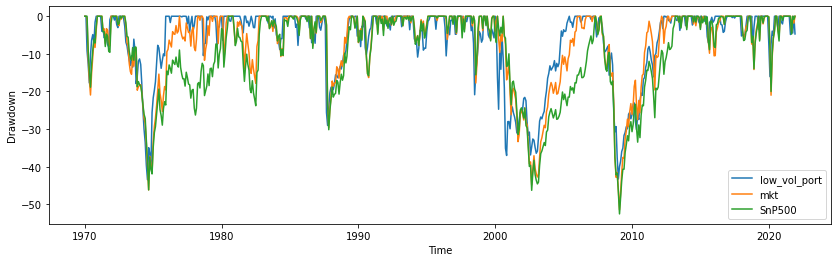

low vol portfolio MDD
 -43.48412679543177

mkt portfolio MDD
 market   -51.478664
SnP500   -52.555687
dtype: float64


In [23]:
#visualization
periods = low_vol.index.get_level_values(level=0).drop_duplicates().to_timestamp()
low_vol_port_cumulative_return = (1+low_vol_port_monthly_return).cumprod()
low_vol_port_cummax = low_vol_port_cumulative_return.cummax()
low_vol_port_drawdown = (low_vol_port_cumulative_return - low_vol_port_cummax)/low_vol_port_cummax*100
low_vol_port_mdd = low_vol_port_drawdown.min()
mkt_cumulative_return = (1+mkt_monthly_return).cumprod()
mkt_cummax = mkt_cumulative_return.cummax()
mkt_drawdown = (mkt_cumulative_return - mkt_cummax)/mkt_cummax*100
mkt_mdd = mkt_drawdown.min()
fig = plt.figure(figsize=(12, 9))
plt.plot(periods, low_vol_port_cumulative_return.values, label='low_vol_port')
plt.plot(periods, mkt_cumulative_return.loc[:'2021-12','market'].values, label='mkt')
plt.plot(periods, mkt_cumulative_return.loc[:'2021-12', 'SnP500'].values, label='SnP500')
plt.xlabel('Time')
plt.ylabel('Total Return')
plt.legend()
plt.show()
fig = plt.figure(figsize=(14, 4))
plt.plot(periods, low_vol_port_drawdown.values, label='low_vol_port')
plt.plot(periods, mkt_drawdown.loc[:'2021-12','market'].values, label='mkt')
plt.plot(periods, mkt_drawdown.loc[:'2021-12', 'SnP500'].values, label='SnP500')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.show()
print("low vol portfolio MDD\n", low_vol_port_mdd)
print("\nmkt portfolio MDD\n", mkt_mdd)

Functionize for generality

In [24]:
monthly_long_beta = (monthly_rebalanced_portfolio['portfolio_weight']*low_vol['beta'].values).groupby(level=0).transform('sum')
monthly_long_beta.reset_index(level=0)

,mdate,portfolio_weight
0,1970-01,0.603773
1,1970-01,0.603773
2,1970-01,0.603773
3,1970-01,0.603773
4,1970-01,0.603773
...,...,...
2626550,2021-12,0.776002
2626551,2021-12,0.776002
2626552,2021-12,0.776002
2626553,2021-12,0.776002


In [25]:
a=(low_vol['beta']*monthly_rebalanced_portfolio['portfolio_weight'].values).groupby(level=0).transform('sum')
b = monthly_rebalanced_portfolio['portfolio_weight'].values*a
b.reset_index(level=1).rename(columns={'beta':'portfolio_weight'}).fillna(0)

,cusip,portfolio_weight
mdate,,
1970-01,000957100,0.000236
1970-01,001007103,0.000744
1970-01,001412105,0.000000
1970-01,001476100,0.000194
1970-01,001688100,0.000000
...,...,...
2021-12,98985X100,0.000060
2021-12,98986M103,0.000039
2021-12,98986T108,0.001147


In [32]:
def low_vol_portfolio(Z_5yBeta_weight=1, Z_5yROEVol_weight=1,Z_5yPriceVol_weight=1, long_quantile=0.3, short_quantile=1, market_neutral=False,rebalancing_period=18):
    #scoring
    low_vol['score'] = low_vol['Z_5yBeta']*Z_5yBeta_weight+low_vol['Z_5yROEVol']*Z_5yROEVol_weight+low_vol['Z_5yPriceVol']*Z_5yPriceVol_weight
    #construct portfolio
    print("Constructing Portfolio")
    monthly_long_selected = low_vol.groupby(level=0).apply(lambda x: x['score']<x['score'].quantile(long_quantile)).reset_index(level=1).drop(columns=['mdate'])
    monthly_long_rebalanced_portfolio = low_vol['cap'].copy()
    monthly_long_rebalanced_portfolio.loc[~monthly_long_selected['score']]=0
    monthly_long_rebalanced_portfolio = monthly_long_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'}).fillna(0)
    monthly_short_selected = low_vol.groupby(level=0).apply(lambda x: x['score']>x['score'].quantile(short_quantile)).reset_index(level=1).drop(columns=['mdate'])
    monthly_short_rebalanced_portfolio = low_vol['cap'].copy()
    monthly_short_rebalanced_portfolio.loc[~monthly_short_selected['score']]=0
    monthly_short_rebalanced_portfolio = monthly_short_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'}).fillna(0)
    if(market_neutral):
        monthly_long_beta = (low_vol['beta']*monthly_long_rebalanced_portfolio['portfolio_weight'].values).groupby(level=0).transform('sum')
        monthly_short_beta = (low_vol['beta']*monthly_short_rebalanced_portfolio['portfolio_weight'].values).groupby(level=0).transform('sum')
        monthly_long_portion = monthly_short_beta/(monthly_long_beta+monthly_short_beta)
        monthly_short_portion = - monthly_long_beta/(monthly_long_beta+monthly_short_beta)
        monthly_long_rebalanced_portfolio = monthly_long_rebalanced_portfolio['portfolio_weight'].values*monthly_long_portion
        monthly_short_rebalanced_portfolio = monthly_short_rebalanced_portfolio['portfolio_weight'].values*monthly_short_portion
        monthly_rebalanced_portfolio = (monthly_long_rebalanced_portfolio + monthly_short_rebalanced_portfolio).reset_index(level=1).rename(columns={'beta':'portfolio_weight'}).fillna(0)
        monthly_rebalanced_portfolio['portfolio_weight'] = monthly_rebalanced_portfolio['portfolio_weight'].groupby(level=0).apply(lambda x:x/x.sum())
    else:
        monthly_rebalanced_portfolio = (monthly_long_rebalanced_portfolio[['portfolio_weight']] + monthly_short_rebalanced_portfolio[['portfolio_weight']])
        monthly_rebalanced_portfolio['cusip'] = monthly_long_rebalanced_portfolio['cusip']
    rebalance_interval = pd.DateOffset(months=rebalancing_period)
    rebalanced_portfolio = None
    rebalanced_date = None
    custom_rebalanced_portfolio = []
    for month, g in monthly_rebalanced_portfolio.groupby(level=0):
        if(not rebalanced_date or pd.Period(rebalanced_date+rebalance_interval, freq='M')<=month):
            rebalanced_date = month.start_time
            rebalanced_portfolio = g
        rebalanced_portfolio.index=[month]*rebalanced_portfolio.shape[0]
        custom_rebalanced_portfolio.append(rebalanced_portfolio[['cusip', 'portfolio_weight']])
    custom_rebalanced_portfolio = pd.concat(custom_rebalanced_portfolio).rename_axis('mdate').set_index('cusip',append=True)
    print(custom_rebalanced_portfolio)
    #result
    print("Calculating Returns")
    low_vol_port_monthly_return = pd.DataFrame(custom_rebalanced_portfolio['portfolio_weight'].multiply(low_vol['return'], axis='index'))
    low_vol_port_monthly_return = low_vol_port_monthly_return.loc[low_vol_port_monthly_return.index.isin(custom_rebalanced_portfolio.index), :]
    delisting_fillup = low_vol_port_monthly_return.groupby(level=1).apply(lambda x: x.isna().idxmin())
    low_vol_port_monthly_return.loc[delisting_fillup[0].values,:] = low_vol_port_monthly_return.loc[delisting_fillup[0].values,:].apply(lambda x : (~x.isna())*x.fillna(0)+x.isna()*(-custom_rebalanced_portfolio.loc[delisting_fillup[0].values,'portfolio_weight']))
    low_vol_port_monthly_return.fillna(0, inplace=True)
    low_vol_port_monthly_return = low_vol_port_monthly_return.groupby(level=0).sum()[0]
    print(low_vol_port_monthly_return)
    print("Summarizing Results")
    low_vol_annual_return = (1+low_vol_port_monthly_return).resample('A').prod()-1
    low_vol_port_total_return = (1+low_vol_annual_return).prod()
    low_vol_port_return_std = low_vol_annual_return.std()
    low_vol_port_excess_return_arithematic_avg = (low_vol_annual_return-annual_mkt_data.loc[:'2022','risk_free']).mean()
    #visualization
    print("Visualizing")
    periods = low_vol.index.get_level_values(level=0).drop_duplicates().to_timestamp()
    low_vol_port_cumulative_return = (1+low_vol_port_monthly_return).cumprod()
    low_vol_port_cummax = low_vol_port_cumulative_return.cummax()
    low_vol_port_drawdown = (low_vol_port_cumulative_return - low_vol_port_cummax)/low_vol_port_cummax*100
    low_vol_port_mdd = low_vol_port_drawdown.min()
    fig = plt.figure(figsize=(12, 9))
    plt.plot(periods, np.log(low_vol_port_cumulative_return.values), label='low_vol_port')
    plt.plot(periods, np.log(mkt_cumulative_return.loc[:'2021-12', 'market'].values), label='market')
    plt.xlabel('Time')
    plt.ylabel('Total Return-log scale')
    plt.legend()
    plt.show()
    fig = plt.figure(figsize=(14, 4))
    plt.plot(periods, low_vol_port_drawdown.values, label='low_vol_port')
    plt.plot(periods, mkt_drawdown.loc[:'2021-12', 'market'].values, label='market')
    plt.xlabel('Time')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.show()
    print("Total Compounded Annual Return(1970-2021)\nLow Vol Port :", low_vol_port_total_return)
    print("market :", mkt_return_total_return['market'])
    print("\nSharp\nLow Vol Port :", low_vol_port_excess_return_arithematic_avg/low_vol_port_return_std)
    print("market :", mkt_excess_return_arithematic_avg['market']/mkt_return_std['market'])
    print("\nMDD\nlow vol portfolio :", low_vol_port_mdd)
    print("market :", mkt_mdd['market'])
    return low_vol_port_monthly_return

Constructing Portfolio


<ipython-input-26-2fec45eb736a>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  monthly_long_rebalanced_portfolio = monthly_long_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'}).fillna(0)
<ipython-input-26-2fec45eb736a>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

                   portfolio_weight
mdate   cusip                      
1970-01 000957100          0.000390
        001007103          0.001232
        001412105          0.000000
        001476100          0.000322
        001688100          0.000000
...                             ...
2021-12 98985X100          0.000122
        98986M103          0.000059
        98986T108          0.000889
        98986X109          0.000000
        G65163100          0.000631

[2620752 rows x 1 columns]
Calculating Returns
mdate
1970-01    0.067860
1970-02    0.016032
1970-03   -0.091640
1970-04   -0.039055
1970-05   -0.052960
             ...   
2021-08   -0.045670
2021-09    0.046034
2021-10   -0.028177
2021-11    0.038952
2021-12   -0.072304
Freq: M, Name: 0, Length: 624, dtype: float64
Summarizing Results
Visualizing


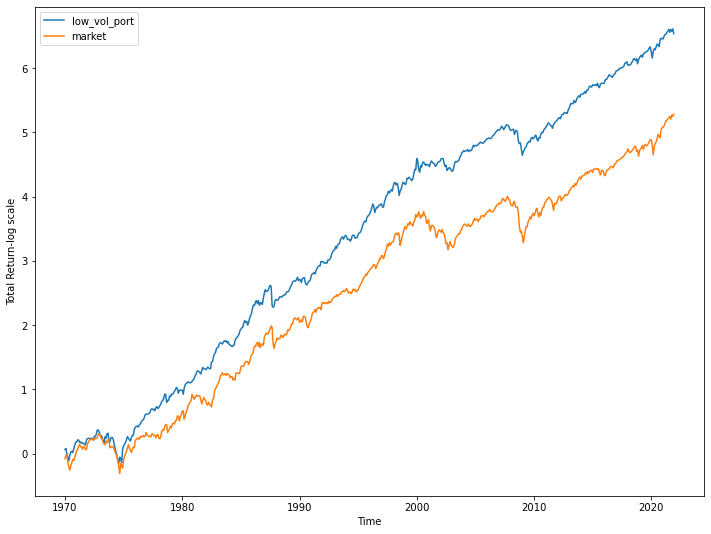

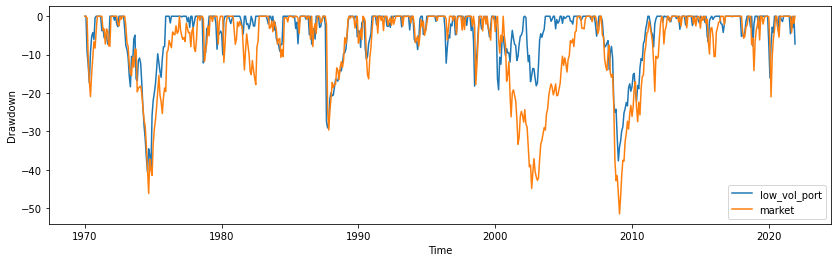

Total Compounded Annual Return(1970-2021)
Low Vol Port : 688.0799863816907
market : 186.34551988332757

Sharp
Low Vol Port : 0.7272927670090165
market : 0.4281772382573811

MDD
low vol portfolio : -40.587514767081856
market : -51.47866447611208


In [27]:
returns = low_vol_portfolio(Z_5yBeta_weight=1, Z_5yROEVol_weight=1, Z_5yPriceVol_weight=1, long_quantile=0.3, short_quantile=1, market_neutral=False, rebalancing_period=3)

Constructing Portfolio


<ipython-input-26-2fec45eb736a>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  monthly_long_rebalanced_portfolio = monthly_long_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'}).fillna(0)
<ipython-input-26-2fec45eb736a>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

                   portfolio_weight
mdate   cusip                      
1970-01 000957100          0.000390
        001007103          0.001232
        001412105          0.000000
        001476100          0.000322
        001688100          0.000000
...                             ...
2021-12 98986M103          0.000045
        98986T108          0.000936
        98986X109          0.000000
        G2124G112          0.000003
        G6S34K105          0.000000

[2615586 rows x 1 columns]
Calculating Returns
mdate
1970-01    0.067860
1970-02    0.016032
1970-03   -0.091640
1970-04   -0.039853
1970-05   -0.056666
             ...   
2021-08   -0.045670
2021-09    0.046034
2021-10   -0.027372
2021-11    0.053497
2021-12   -0.064123
Freq: M, Name: 0, Length: 624, dtype: float64
Summarizing Results
Visualizing


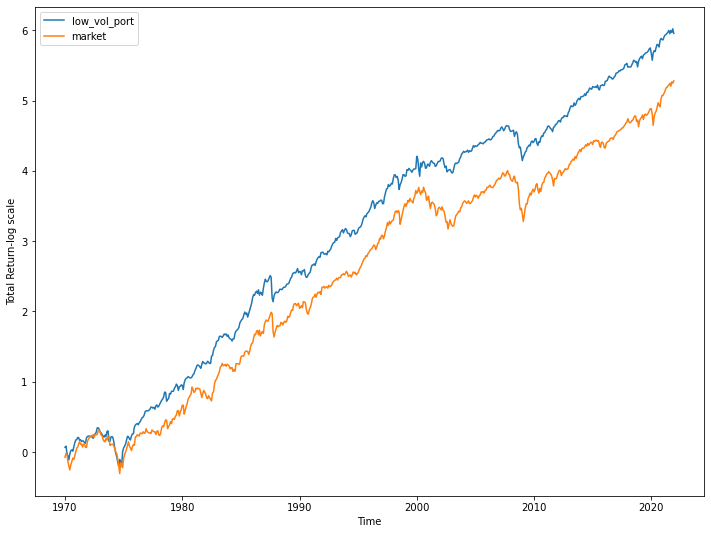

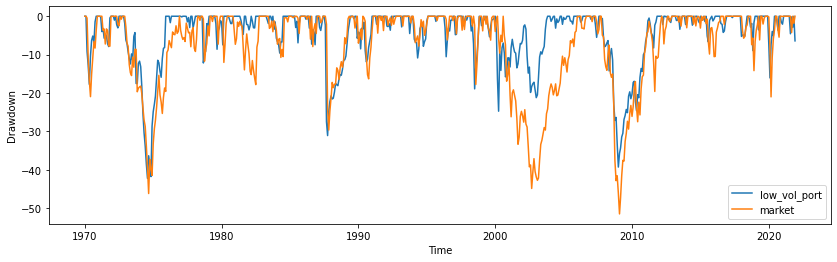

Total Compounded Annual Return(1970-2021)
Low Vol Port : 385.94286541578924
market : 186.34551988332757

Sharp
Low Vol Port : 0.6278136198411027
market : 0.4281772382573811

MDD
low vol portfolio : -42.23103740775623
market : -51.47866447611208


In [28]:
returns = low_vol_portfolio(Z_5yBeta_weight=1, Z_5yROEVol_weight=1, Z_5yPriceVol_weight=1, long_quantile=0.3, short_quantile=1, market_neutral=False, rebalancing_period=6)

Constructing Portfolio


<ipython-input-26-2fec45eb736a>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  monthly_long_rebalanced_portfolio = monthly_long_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'}).fillna(0)
<ipython-input-26-2fec45eb736a>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

                   portfolio_weight
mdate   cusip                      
1970-01 000957100          0.000969
        001007103          0.003059
        001412105          0.000272
        001476100          0.000799
        001688100          0.007777
...                             ...
2021-12 98986M103          0.000000
        98986T108          0.013922
        98986X109          0.000000
        G2124G112          0.000053
        G6S34K105          0.000038

[2603868 rows x 1 columns]
Calculating Returns
mdate
1970-01    0.065659
1970-02    0.005319
1970-03   -0.103651
1970-04   -0.056862
1970-05   -0.053873
             ...   
2021-08   -0.024041
2021-09    0.029958
2021-10   -0.040532
2021-11    0.015235
2021-12   -0.056325
Freq: M, Name: 0, Length: 624, dtype: float64
Summarizing Results
Visualizing


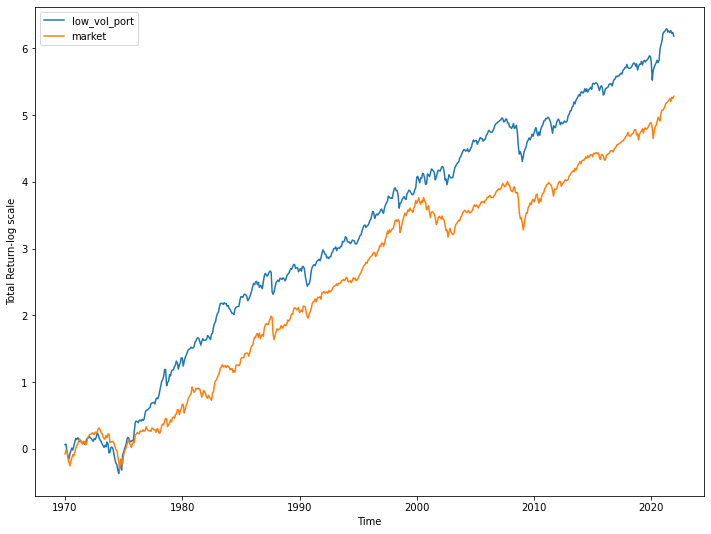

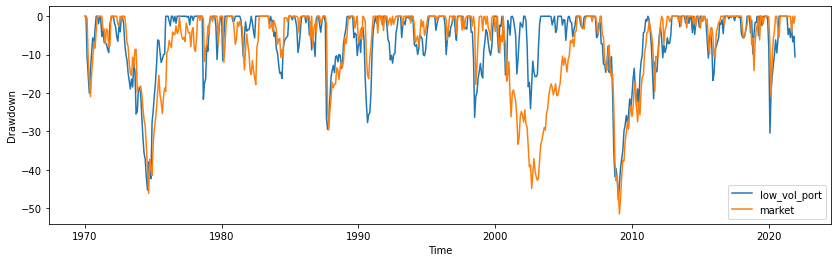

Total Compounded Annual Return(1970-2021)
Low Vol Port : 483.7668678351017
market : 186.34551988332757

Sharp
Low Vol Port : 0.5400516392164106
market : 0.4281772382573811

MDD
low vol portfolio : -47.85598007246376
market : -51.47866447611208


In [29]:
returns = low_vol_portfolio(Z_5yBeta_weight=0, Z_5yROEVol_weight=0, Z_5yPriceVol_weight=1, long_quantile=0.3, short_quantile=1, market_neutral=False, rebalancing_period=12)

### Conclusion
low_vol_port constructed only by 30% low price volatility equityies had high sharp than market portfolio. It even turned out to acheive higher return when it is rebalanced semiannauly, or mort frequently. However this model is not considering the transaction cost and this result may not be realistic. 

<h3>Problem 2. Low Volatility – Long/Short Portfolio</h3>
<ol>
<li>Data Load – Long Portfolio와 동일</li>
<li>Z-Scoring – Long Portfolio와 동일</li>
<li>Score Aggregation – Long Portfolio와 동일</li>
<li>Construct Long/Short Portfolio<br>
    합산된 Z-Score를 기준으로 하위 30% 종목 (변동성이 낮은 종목)을 매수하여 Long Portfolio를, 상위 30% 종목 (변동성이 높은 종목)을 공매도 하여 Short Porftolio를 구성한다.  각 포트폴리오는 시가총액 가중방식을 이용해 구성한다.<br>
    전체 포트폴리오는 Long 포트폴리오에 β<sub>short</sub> / (β<sub>long</sub> + β<sub>short</sub>), Short 포트폴리오에 β<sub>long</sub> / (β<sub>long</sub> + β<sub>short</sub>)만큼 가중치를 부여하여 시장 중립적인 포트폴리오를 구성한다. 즉,<br>
    1. Long Portfolio, Short Portfolio → 시가총액 방식으로 구성<br>
    2. My Portfolio(long-short) = β<sub>short</sub> / (β<sub>long</sub> + β<sub>short</sub>) * Long Portfolio - β<sub>short</sub> / (β<sub>long</sub> + β<sub>short</sub>) * Short Portfolio<br>
    의 방식을 통해 전체 Exposure가 1인 Long-Short 포트폴리오를 구성한다. Long 포트폴리오와 동일하게 18개월 보유 후 보유기간이 종료되는 시점에 리밸런싱을 진행한다.</li>
<li>시장중립 포트폴리오란? : <a href="https://www.investopedia.com/terms/m/marketneutral.asp">https://www.investopedia.com/terms/m/marketneutral.asp</a></li>
<li>Statistical Robustness of Alpha<br>
    위의 방법으로 구성할 경우 포트폴리오의 수익률에서 시장 변동은 제거되고 알파만 남는다. T-test 등을 통해 알파(Long-Short 포트폴리오의 수익률)가 통계적으로 강건하게 0이상임을 보인다.</li>
<li>Visualization<br>
    Long/Short 포트폴리오의 누적수익률 (알파의 누적수익률), MDD 등을 시각화 하여 나타낸다.</li>
</ol>

Constructing Portfolio


<ipython-input-32-e9bf5726b41c>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  monthly_long_rebalanced_portfolio = monthly_long_rebalanced_portfolio.groupby(level=0).apply(lambda x:x/x.sum()).reset_index(level=1).rename(columns={'cap':'portfolio_weight'}).fillna(0)
<ipython-input-32-e9bf5726b41c>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

                   portfolio_weight
mdate   cusip                      
1970-01 000957100          0.000688
        001007103          0.002171
        001412105          0.000000
        001476100          0.000567
        001688100          0.000000
...                             ...
2021-12 98986M103          0.000068
        98986T108          0.001616
        98986X109         -0.000007
        G2124G112          0.000006
        G6S34K105         -0.000002

[2599338 rows x 1 columns]
Calculating Returns
mdate
1970-01    0.081411
1970-02    0.044986
1970-03   -0.073461
1970-04   -0.011217
1970-05   -0.040088
             ...   
2021-08   -0.058452
2021-09    0.025115
2021-10   -0.046660
2021-11    0.097565
2021-12   -0.035256
Freq: M, Name: 0, Length: 624, dtype: float64
Summarizing Results
Visualizing


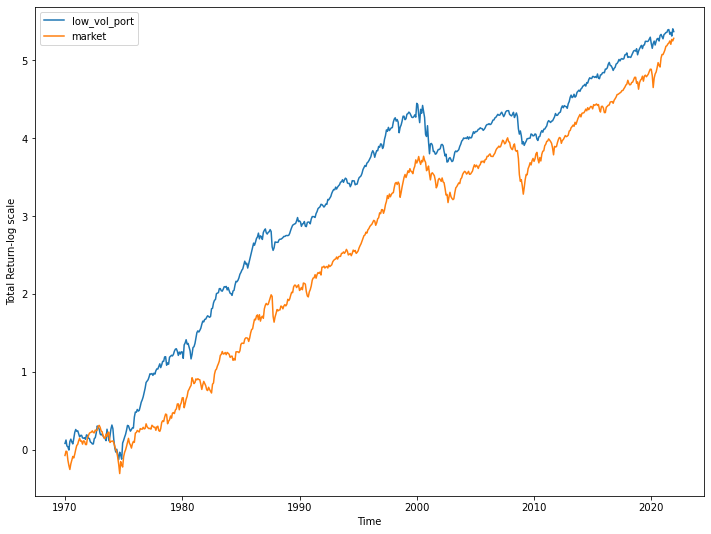

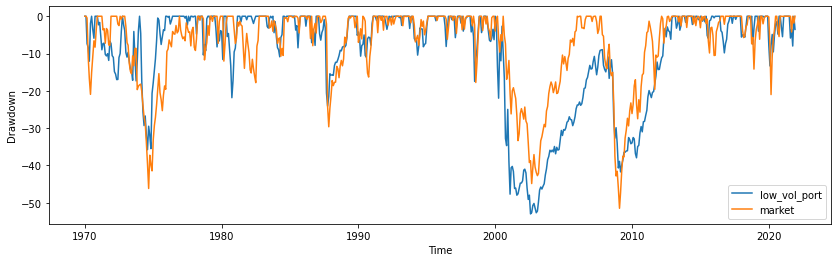

Total Compounded Annual Return(1970-2021)
Low Vol Port : 214.38061574100797
market : 186.34551988332757

Sharp
Low Vol Port : 0.4520253406678642
market : 0.4281772382573811

MDD
low vol portfolio : -52.9881242266959
market : -51.47866447611208


In [34]:
low_vol_long_short_port_montyly_return = low_vol_portfolio(Z_5yBeta_weight=1, Z_5yROEVol_weight=1, Z_5yPriceVol_weight=1, long_quantile=0.3, short_quantile=0.7, market_neutral=True, rebalancing_period=18)

In [35]:
stats.ttest_1samp(low_vol_long_short_port_montyly_return, popmean=0, alternative='greater')

Ttest_1sampResult(statistic=5.395028361564663, pvalue=4.8721346889798504e-08)

since p-value is small enough, we can reject the H0:alpha = 0. But the cumulative graph of mkt-neutral port was considerably similiar to mkt-returns even though mkt neutralization. Therefore, we can conclude that the low-vol factor itself has some correlation with marmet environment.